In [1]:
## Imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport

In [2]:
data=pd.read_csv('C2T1-Cleaned.csv')
data.drop(columns='Unnamed: 0', inplace=True)
#data.info()

In [3]:
data = data.apply(pd.to_numeric, errors='ignore')
data.isnull().any()
duplicates=data[data.duplicated()]
print(duplicates.shape) 

(0, 25)


In [4]:
# Create dummy variables primarily for Gender, Education, and Default
data=pd.get_dummies(data)
print(data.info())

#Run Pandas Profiling, Save to HTML
report=data.profile_report()
report.to_file("C2T1-CleanedEDA.html")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 30 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0   ID                         30000 non-null  int64
 1   LIMIT_BAL                  30000 non-null  int64
 2   MARRIAGE                   30000 non-null  int64
 3   AGE                        30000 non-null  int64
 4   PAY_1                      30000 non-null  int64
 5   PAY_2                      30000 non-null  int64
 6   PAY_3                      30000 non-null  int64
 7   PAY_4                      30000 non-null  int64
 8   PAY_5                      30000 non-null  int64
 9   PAY_6                      30000 non-null  int64
 10  BILL_AMT1                  30000 non-null  int64
 11  BILL_AMT2                  30000 non-null  int64
 12  BILL_AMT3                  30000 non-null  int64
 13  BILL_AMT4                  30000 non-null  int64
 14  BILL_AMT5             

Summarize dataset:   0%|          | 0/44 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
## Creation of new variables per customer: 
#Debt_Usage[1-6]: Monthly Bill as % of Total Limit
#Total_Bill: Total Billed amount throughout period
#Total_Paid: Total paid amount throughout period

DerivedVars=pd.DataFrame()

## Customer cumulatives throughout six month period
DerivedVars['Total_Bill']=data.iloc[:,10:16].sum(axis=1) ## axis part was key difference vs. initial attempts
DerivedVars['Total_Paid']=data.iloc[:,16:22].sum(axis=1)
DerivedVars['Net_Borrow']=DerivedVars['Total_Bill']-DerivedVars['Total_Paid']

## Monthly Debt_Usage 
DerivedVars['Debt_Usage1']=(data['BILL_AMT1'] / data['LIMIT_BAL'])
DerivedVars['Debt_Usage2']=(data['BILL_AMT2'] / data['LIMIT_BAL'])
DerivedVars['Debt_Usage3']=(data['BILL_AMT3'] / data['LIMIT_BAL'])
DerivedVars['Debt_Usage4']=(data['BILL_AMT4'] / data['LIMIT_BAL'])
DerivedVars['Debt_Usage5']=(data['BILL_AMT5'] / data['LIMIT_BAL'])
DerivedVars['Debt_Usage6']=(data['BILL_AMT6'] / data['LIMIT_BAL'])
DerivedVars['Debt_UsageAVG']=(DerivedVars.iloc[:,3:8].sum(axis=1)/6)

print(DerivedVars.info())
print(DerivedVars['Debt_Usage6'].isna().any()) ## No nulls in Total_Bill, _Paid, Net_Borrow, or monthly Debt Usages
#print(DerivedVars.shape)

## Combine with original dataset

New=pd.merge(data,DerivedVars,how='outer', on=data['ID'])
New=New.drop(columns=['key_0'])

## Can't do this given 0's in denominators

#Bill_Percent[1-6]: Paid Amount as % of Previous 

#DerivedVars['Bill_Percent1']=(data['PAY_AMT1'] / data['BILL_AMT1'])
#DerivedVars['Bill_Percent2']=(data['PAY_AMT2'] / data['BILL_AMT2'])
#DerivedVars['Bill_Percent3']=(data['PAY_AMT3'] / data['BILL_AMT3'])
#DerivedVars['Bill_Percent4']=(data['PAY_AMT4'] / data['BILL_AMT4'])
#DerivedVars['Bill_Percent5']=(data['PAY_AMT5'] / data['BILL_AMT5'])
#DerivedVars['Bill_Percent6']=(data['PAY_AMT6'] / data['BILL_AMT6'])
#DerivedVars['Bill_PercentAVG']=((Bill_Percent1+Bill_Percent2+Bill_Percent3+Bill_Percent4+Bill_Percent5+Bill_Percent6))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Total_Bill     30000 non-null  int64  
 1   Total_Paid     30000 non-null  int64  
 2   Net_Borrow     30000 non-null  int64  
 3   Debt_Usage1    30000 non-null  float64
 4   Debt_Usage2    30000 non-null  float64
 5   Debt_Usage3    30000 non-null  float64
 6   Debt_Usage4    30000 non-null  float64
 7   Debt_Usage5    30000 non-null  float64
 8   Debt_Usage6    30000 non-null  float64
 9   Debt_UsageAVG  30000 non-null  float64
dtypes: float64(7), int64(3)
memory usage: 2.3 MB
None
False


In [6]:
## Even more dummy variables to explore other potential dynamics in the data

## New dummy for anything BUT single status
New['PrevRel'] = ((New['MARRIAGE'] !=2)).astype(int) 

## Education is University or higher
New['ED_CollegePlus'] = ((New['EDUCATION_university'] == 1) | (New['EDUCATION_graduate school'] == 1) *1)
New['ED_CollegePlus'] = (New['ED_CollegePlus']).astype(int)

# Code as 1 if they're at least 1 month late
New['Behind1'] = (New['PAY_1'] >= 1).astype(int)
New['Behind2'] = (New['PAY_2'] >= 1).astype(int)
New['Behind3'] = (New['PAY_3'] >= 1).astype(int)
New['Behind4'] = (New['PAY_4'] >= 1).astype(int)
New['Behind5'] = (New['PAY_5'] >= 1).astype(int)
New['Behind6'] = (New['PAY_6'] >= 1).astype(int)
New['EvBehind'] = New.loc[:,'Behind1':'Behind6'].any(axis=1).astype(int)

# Mean of customer's PAY_ status codes over the six months
# Higher values signify tend to pay late, per supplement coding
New['AvgPayTime']=(New.loc[:,'PAY_1':'PAY_6'].mean(axis=1))

print(New.info())

##Never got these working

#New['EvBehind']=New.apply(lambda row: any(New[:,'Behind1':'Behind6']))
#for row in New.iterrows():
    #if any(New.loc[:,'Behind1':'Behind6'] >=1):
      #  New['EvBehind']=1 
#for row in New.iterrows():
    #New['AvgPayTime'] = New.loc[:,'PAY_1':'PAY_6'].mean()
    

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 0 to 29999
Data columns (total 50 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   ID                         30000 non-null  int64  
 1   LIMIT_BAL                  30000 non-null  int64  
 2   MARRIAGE                   30000 non-null  int64  
 3   AGE                        30000 non-null  int64  
 4   PAY_1                      30000 non-null  int64  
 5   PAY_2                      30000 non-null  int64  
 6   PAY_3                      30000 non-null  int64  
 7   PAY_4                      30000 non-null  int64  
 8   PAY_5                      30000 non-null  int64  
 9   PAY_6                      30000 non-null  int64  
 10  BILL_AMT1                  30000 non-null  int64  
 11  BILL_AMT2                  30000 non-null  int64  
 12  BILL_AMT3                  30000 non-null  int64  
 13  BILL_AMT4                  30000 non-null  int

Monthly aggregate customer bills have increased from: 1166152812 to  1536699927 over the period
This is an increase of 0.3177517656236634 percent.

Monthly aggregate customer payments have increased from: 156465077 to  169907415 over the period
This is an increase of 0.08591270498016627 percent.
Customer average debt usage (calculated as Monthly Bill % of Limit) steadily increased over the period from 0.31858494825363615 to 0.42377145132492255

 This is an increase of 0.3301678363898847 percent


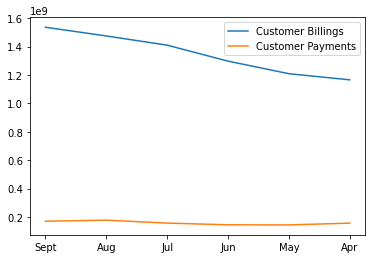

In [7]:
### Gross/net borrowing $ figures per month
Monthly=['Sept','Aug','Jul','Jun','May','Apr']

Total_Bill=New.iloc[:,10:16].sum() ## Not what I intended to do, but this is total billed amount per period
Total_Paid=New.iloc[:,16:22].sum() ## Paid for each month

## While customer bills have increased steadily, their payments have not followed suit, i.e. Credit One more exposed
sns.lineplot(x=Monthly, y=Total_Bill, data=Total_Bill, label='Customer Billings')
sns.lineplot(x=Monthly, y=Total_Paid, data=Total_Paid, label='Customer Payments')
print('Monthly aggregate customer bills have increased from:',Total_Bill[5],'to ',Total_Bill[0],'over the period')
print('This is an increase of',((Total_Bill[0]-Total_Bill[5])/Total_Bill[5]), 'percent.')
print('\nMonthly aggregate customer payments have increased from:',Total_Paid[5],'to ',Total_Paid[0],'over the period')
print('This is an increase of',((Total_Paid[0]-Total_Paid[5])/Total_Paid[5]), 'percent.')

## Trending analysis of customers behind at least 1 month, for any given month

New['Behind1'].value_counts()
New['Behind2'].value_counts()
New['Behind3'].value_counts()
New['Behind4'].value_counts()
New['Behind5'].value_counts()
New['Behind6'].value_counts()

print('Customer average debt usage (calculated as Monthly Bill % of Limit) steadily increased over the period from',
     New['Debt_Usage6'].mean(),'to',New['Debt_Usage1'].mean())
print('\n This is an increase of',(New['Debt_Usage1'].mean()-New['Debt_Usage6'].mean())/New['Debt_Usage6'].mean(),'percent')

#print(New['Behind1'].value_counts()) ##6818 late
#print(New['Behind2'].value_counts()) ##4438
#print(New['Behind3'].value_counts()) ##4213
#print(New['Behind4'].value_counts()) ##3510
#print(New['Behind5'].value_counts()) ##2968
#print(New['Behind6'].value_counts()) #3070

#print('Credit One customers have a total credit limit of',(New['LIMIT_BAL'].sum()))
#print((Total_Bill[5])/(New['LIMIT_BAL'].sum()))

#print(New['Debt_Usage1'].mean())
#print(New['Debt_Usage2'].mean())
#print(New['Debt_Usage3'].mean())
#print(New['Debt_Usage4'].mean())
#print(New['Debt_Usage5'].mean())
#print(New['Debt_Usage6'].mean())


In [ ]:
## Split into two different dataframes to ease comparative analysis later
InDefault = New[New['def_next_default'] == 1]
NoDefault = New[New['def_next_default'] == 0]

#InDefault.describe()

##Seaborn Visualizations, Groupbys, and Findings THereof

#Age
#sns.violinplot(x='def_next_default', y='AGE', data=New) ## Violins look similarly same
#sns.boxplot(x=data['def_next_default'], y='AGE', data=New) ## No material difference in age b/w default status
#sns.stripplot(x='def_next_default', y=data['AGE'], data=New) ## Likewise, thus age appears to be little factor
#sns.displot(data, x="AGE", hue="def_next_default", bins=15, element="step") ## Both distributions skew right
#print(New['AGE'].groupby(New['def_next_default']).describe()) #Mean age almost identical for default/non-default

#Education -- CIRCLE BACK
## Need percents and/or normalize against total counts of college incidence, b/c this suggests College Plus
## Or look into ordinal encoding of Education level?
#sns.catplot('def_next_default', hue='ED_CollegePlus', data=New, kind='count') 

#Gender - Those in Default are less likely to be female (0.567 vs. 0.614) but may not be stat. significant?
#sns.violinplot(x='def_next_default', y='SEX_female', data=New)
#sns.violinplot(x='SEX_female', y='def_next_default', data=New)
#print(New['SEX_female'].groupby(New['def_next_default']).describe())

#Limit_BAL - Those Not in Default have higher Limits overall 178K vs. 130K
#sns.boxplot(y='LIMIT_BAL', x='def_next_default', data=New, showfliers=False)
#print(New['LIMIT_BAL'].groupby(New['def_next_default']).describe())

#Debt_UsageAVG - Shows those defaulting indeed carry bills that are a larger share of total credit limit
#sns.boxplot(y='Debt_UsageAVG', x='def_next_default', data=New, showfliers=False)
#print(New['Debt_UsageAVG'].groupby(New['def_next_default']).describe())

#Net_Borrow - Almost identical Net_Borrow means for both segments, slightly more for Default
#sns.boxplot(y='Net_Borrow', x='def_next_default', data=New, showfliers=False)
#print(New['Net_Borrow'].groupby(New['def_next_default']).describe())

#AvgPayTime - Those Not in Default have sig. lower payment code (mean of -0.33 vs. 0.33; median of 0 vs. 0.33)
#sns.boxplot(y='AvgPayTime', x='def_next_default', data=New, showfliers=False)
#print(New['AvgPayTime'].groupby(New['def_next_default']).describe())

#EvBehind - Those in Default have mean of .64 vs. 0.24; Violin plot shows Non-defaults also fall behind on payments
#sns.violinplot(y=New['EvBehind'], x='def_next_default', data=New)
#print(New['EvBehind'].groupby(New['def_next_default']).describe())

#ED_CollegePlus - Those in Default have mean of .64 vs. 0.24; Violin plot shows Non-defaults also fall behind on payments
#sns.violinplot(y=New['ED_CollegePlus'], x='def_next_default', data=New)
#print(New['ED_CollegePlus'].groupby(New['def_next_default']).describe())

#Previous Relationship - Those in Default marginally more likely to have one..Mean 0.50 vs. 0.46
#sns.violinplot(y='PrevRel', x='def_next_default', data=New)
#print(New['PrevRel'].groupby(New['def_next_default']).describe())
#print(New['def_next_default'].groupby(New['PrevRel']).describe())

In [ ]:
## Correlation Matrix

Summary=New[['ID','def_next_default','LIMIT_BAL','AGE','SEX_female','Debt_UsageAVG','Total_Bill','Total_Paid','Net_Borrow',
           'ED_CollegePlus','PrevRel','EvBehind','AvgPayTime']].copy().astype(int)

corr = Summary.corr().reset_index()
print(corr)

sns.heatmap(Summary.corr(),vmin=-1, vmax=1, cmap='BrBG', center=0);

#sns.set_theme(style="white")
#cmap = sns.diverging_palette(230, 20, as_cmap=True)
#mask = np.triu(np.ones_like(corr, dtype=bool))
#f, ax = plt.subplots(figsize=(11, 9))
#sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            #square=True, linewidths=.5, cbar_kws={"shrink": .5})





In [ ]:
## Payment status for each month
## -2: No spending; -1: Paid in full; 0: The use of revolving credit; 1 = payment delay
# for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months

#print(data['PAY_1'].groupby(data['def_next_default']).value_counts())
## This shows 954 customers with PAY_1 status of "Paid in full" that are still  default?

#Pay1=data['def_next_default'].groupby(data['PAY_1']).value_counts()
#print(Pay1)

fgs = sns.catplot(x='PAY_1', data=New, kind='count', aspect=1.5, hue="def_next_default")
fgs.set_xlabels('Sept 2005 Payment Status')
fgs = sns.catplot(x='PAY_2', data=New, kind='count', aspect=1.5, hue="def_next_default")
fgs.set_xlabels('Aug 2005')
fgs = sns.catplot(x='PAY_3', data=New, kind='count', aspect=1.5, hue="def_next_default")
fgs.set_xlabels('July 2005')
fgs = sns.catplot(x='PAY_4', data=New, kind='count', aspect=1.5, hue="def_next_default")
fgs.set_xlabels('June 2005')
fgs = sns.catplot(x='PAY_5', data=New, kind='count', aspect=1.5, hue="def_next_default")
fgs.set_xlabels('May 2005')
fgs = sns.catplot(x='PAY_6', data=New, kind='count', aspect=1.5, hue="def_next_default")
fgs.set_xlabels('April 2005')

#fg.set_xlabels('Sept 2005 Payment Status') ## Good standing PAY_1 status [-2,0] still has customers in default

# Not all 1+ month late customers are deemed in default, even some 2 and 3 months
## ---> QUESTION IS WHAT DEEMS THEM IN DEFAULT
